Давайте подивимося, як LSTM можна використовувати для побудови нейронної мережі прогнозування часових.

Будемо працювати з задачею прогнозування кількості пасажирів міжнародних авіаліній. З цим набором даних ми вже працювали в лекції "Time Series Analysis" і ви зможете порівняти результати :)

Задача полягає в тому, щоб за заданими роком і місяцем передбачити кількість пасажирів міжнародних авіаліній в одиницях виміру 1,000. Дані охоплюють період з січня 1949 року по грудень 1960 року, тобто 12 років, зі 144 спостереженнями.

Це регресійна задача. Тобто, знаючи кількість пасажирів (в тисячах) за останні місяці, можна передбачити, якою буде кількість пасажирів у наступному місяці. Набір даних має лише одну характеристику: "Кількість пасажирів" - `Passengers`.

Далі вже наведений код для читання даних, але нам їх ще треба буде трошки обробити.

In [58]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"


In [59]:
df = pd.read_csv(url)

In [60]:
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


**Завдання 1.** Створіть змінну типу `numpy.ndarray`, яка містить значення кількості пасажирів в форматі `float32`. Такий формат даних нам треба для тренування нейромережі.

In [61]:
passengers_array = np.array(df['Passengers'], dtype=np.float32)
passengers_array

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.], dtype=float32)

Очікуваний результат:
```array([112., 118., 132., 129., 121.], dtype=float32)```

**Завдання 2**. Розбийте дані на тренувальні і валідаційні у співвідношенні 67% йде у тренування, 33 - у валідацію. Памʼятаємо, що ми працюємо з tim series, відповідно, навчаємось на давніших, валідуємось - на новіших.

In [62]:
# Кількість даних
n = len(passengers_array)

# Розділяємо у співвідношенні 67% на 33%
train_size = int(n * 0.67)

# Тренувальні дані (перші 67%)
train = passengers_array[:train_size]

# Валідаційні дані (останні 33%)
test = passengers_array[train_size:]

**Завдання 3**.

Реалізуйте функцію `create_dataset`, яка перетворить одномірний часовий ряд (набір даних) у формат, придатний для тренування нейромережі.

Функція повинна приймати два аргументи:
- `dataset` — numpy-масив часового ряду,
- `lookback` — кількість попередніх кроків, які використовуватимуться для передбачення.

Функція повинна повернути два **тензори** PyTorch:
- `X` — набір ознак (вікно попередніх значень),
- `y` — цільові значення (наступні після вікна кроки).

Дані ми будемо подавати моделі в наступному форматі:
`
tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.]])
`
Відповідно першою розмірністю буде йти розмір вхідного батча, а другою - розмір вхіднизх даних і в нас це 1, бо лише одне значення на вході щоразу.

Після виконання завдання запустіть код нижче. Ми будемо передбачати на основі кількості пасажирів в попередній день кількість пасажирів в наступний, тому `lookback == 1`.

In [63]:
import torch

def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        # Створюємо вікно попередніх значень (features)
        window = dataset[i:i + lookback]
        # Цільове значення — наступний елемент після вікна
        target = dataset[i + lookback]
        X.append(window)
        y.append(target)

    # Перетворюємо списки у тензори
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  # Додаємо вимір для batch

    return X, y

In [64]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])


Очікуваний результат:
```
torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])
```

**Завдання 4**.

Зверніть увагу на розмірності в попередньому завданні. Ми
З допомогою модуля `torch.nn` опишіть клас `AirModel`, який є нейронною мережею для прогнозування кількості пасажирів за допомогою LSTM.

1. **Конструктор класу** повинен приймати параметри `hidden_size`, `num_layers` та ініціювати шари:
   - LSTM-шар з наступними параметрами:
     - `input_size` — кожна точка часового ряду є окремим входом,,
     - `hidden_size` — заданий в конструкторі класу мережі,
     - `num_layers=1` — кількість шарів LSTM, задана в конструкторі мережі,
     - `batch_first=True` — визначає, що першим виміром є розмір батчу.
   - Лінійний шар (`nn.Linear`) для перетворення виходу LSTM на прогноз однієї точки.

2. **Метод forward** повинен виконувати наступні дії:
   - Передати вхідний тензор через LSTM-шар і отримати виходи (ігноруючи приховані стани).
   - Пропустити вихід LSTM через лінійний шар для отримання остаточного прогнозу.

Створіть об'єкт класу `AirModel` зі значеннями параметрів `hidden_size=50`, `num_layers=1` і протестуйте роботу моделі на вхідному тензорі `tensor([[112.]])`. На цьому етапі ми маємо переконатись, що модель здатна генерувати передбачення з рандомно ініційованими вагами.

In [77]:
X_train = X_train.view(-1, 1, 1)
X_test = X_test.view(-1, 1, 1)

In [91]:
import torch
import torch.nn as nn

class AirModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(AirModel, self).__init__()

        # LSTM шар
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Лінійний шар
        self.linear = nn.Linear(hidden_size, 1)


    def forward(self, x):
        out, _ = self.lstm(x)
        # Беремо лише значення на останньому time step для передбачення класу
        out = self.linear(out[:, -1, :])
        return out


In [92]:
# Параметри моделі
input_size = 1  # Кожен вхід - це одна точка часового ряду
hidden_size = 50  # Розмір прихованого шару
num_layers = 1  # Кількість шарів LSTM

# Створюємо модель
model = AirModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
model

AirModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [93]:
x = torch.tensor([[112.]])
x = x.view(-1, 1, 1)
output = model(x)
print(output)

tensor([[0.3901]], grad_fn=<AddmmBackward0>)


**Завдання 5**.

Створіть об'єкт DataLoader для завантаження даних, використовуючи тренувальні вибірки `X_train` та `y_train`. Ваш DataLoader повинен виконувати наступні вимоги:

1. Використовувати клас `TensorDataset`, щоб об'єднати тензори ознак `X_train` і цільових значень `y_train`.
2. Дані повинні завантажуватися невеликими батчами розміром 8 за допомогою параметра `batch_size`.
3. Використовувати параметр `shuffle=True`, щоб дані перемішувалися перед кожною епохою тренування.


In [81]:
from torch.utils.data import TensorDataset, DataLoader
train_ds = TensorDataset(X_train, y_train)

In [82]:
# Визначаємо data loader
batch_size = 8
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

**Завдання 6**.

1. Реалізуйте навчання нейронної мережі `AirModel` для прогнозування часових рядів, використовуючи Adam-оптимізатор та функцію втрат MSE (середньоквадратичну похибку).
2. Створіть цикл тренування для 2000 епох, у якому на кожній епосі:
   - Виконуйте крок тренування моделі (прямий прохід, обчислення похибки, зворотний прохід і оновлення ваг).
   - Підраховуйте середню похибку на кожному батчі даних і зберігайте її у списку `losses`.
3. Раз на 100 епох проводьте валідацію моделі:
   - Перевіряйте модель на тренувальних та тестових даних без оновлення ваг.
   - Обчислюйте корінь середньоквадратичної похибки (RMSE) для тренувальної та тестової вибірок і виводьте результати на екран.
   
**Примітка:**
- Використовуйте вже створений `DataLoader` для отримання батчів даних.
- Валідацію виконуйте в режимі `eval()`, вимикаючи обчислення градієнтів з `torch.no_grad()`.

**Приклад виходу:**
```
Epoch 0: train RMSE 12.3456, test RMSE 15.6789
Epoch 100: train RMSE 9.8765, test RMSE 12.3456
...
```

In [94]:
def train( model, criterion, optimizer, xb, yb):
    optimizer.zero_grad()
    output = model(xb)
    loss = criterion(output, yb)
    loss.backward()
    optimizer.step()

    return output, loss.item()

In [95]:

n_iters = 2000
plot_every = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Збираємо лоси для графіку
all_epoch_losses = []  # Втрати по епохах
all_batch_losses = []  # Втрати по батчах


for iter in range(n_iters):
    total_loss = 0  # Загальна втрата за епоху

    # Проходимо по кожному батчу
    for xb, yb in train_dl:
        output, loss = train(model, criterion, optimizer, xb, yb)
        total_loss += loss

        # Зберігаємо втрату для кожного батчу
        all_batch_losses.append(loss)

    # Обчислюємо середню втрату за епоху
    average_loss = total_loss / len(train_dl)
    all_epoch_losses.append(average_loss)

     # Валідація раз на 100 епох
    if iter % plot_every == 0:
        model.eval()
        with torch.no_grad():
            train_outputs = model(X_train)
            test_outputs = model(X_test)

            train_rmse = torch.sqrt(criterion(train_outputs, y_train)).item()
            test_rmse = torch.sqrt(criterion(test_outputs, y_test)).item()

            print(f'Epoch {iter}: train RMSE: {train_rmse:.4f}, test RMSE: {test_rmse:.4f}')

Epoch 0: train RMSE: 225.6134, test RMSE: 421.9991
Epoch 100: train RMSE: 187.7054, test RMSE: 382.3561
Epoch 200: train RMSE: 156.3720, test RMSE: 348.6842
Epoch 300: train RMSE: 128.7722, test RMSE: 317.6375
Epoch 400: train RMSE: 105.4471, test RMSE: 289.1043
Epoch 500: train RMSE: 87.1400, test RMSE: 263.4398
Epoch 600: train RMSE: 70.6143, test RMSE: 238.8548
Epoch 700: train RMSE: 57.6117, test RMSE: 215.9152
Epoch 800: train RMSE: 47.2583, test RMSE: 195.1264
Epoch 900: train RMSE: 39.6839, test RMSE: 176.5972
Epoch 1000: train RMSE: 33.8041, test RMSE: 160.5196
Epoch 1100: train RMSE: 30.0616, test RMSE: 146.8513
Epoch 1200: train RMSE: 27.7228, test RMSE: 135.7821
Epoch 1300: train RMSE: 26.1755, test RMSE: 126.9609
Epoch 1400: train RMSE: 25.8380, test RMSE: 120.7529
Epoch 1500: train RMSE: 24.7269, test RMSE: 114.8156
Epoch 1600: train RMSE: 24.1473, test RMSE: 110.0030
Epoch 1700: train RMSE: 26.6556, test RMSE: 105.8047
Epoch 1800: train RMSE: 23.6355, test RMSE: 104.1999


**Завдання 7.** Побудуйте графік лосів. Зробіть висновок з графіку, чи навчилась модель?

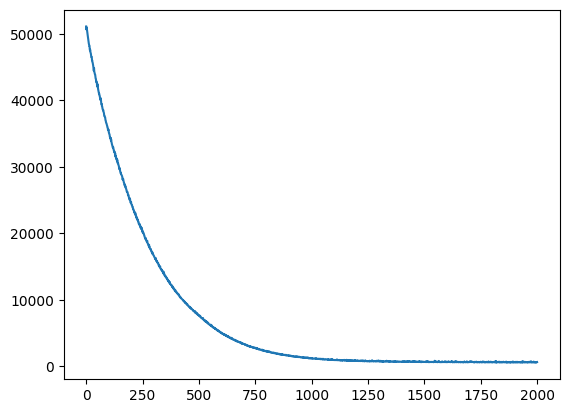

In [97]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.plot(all_epoch_losses);

**Висновки:**
Модель навчилась на  тренувальних даних добре, але на тестових даних втрати великі.

Модель навчилась, але не факт, що точно)

Доволі неочікувано, що середньоквадратичне відхилення тестового набору даних буде на порядок більшим за одиниці в нашому наборі даних. Середньоквадратичне відхилення 100 означає, що прогноз і фактичне значення будуть відрізнятися в середньому на 100 (тобто, 100 000 пасажирів у цьому наборі даних).



Щоб краще зрозуміти якість прогнозу, ви можете побудувати графік з кодом нижче (а ще нижче - описано, що відбувається в цьому коді, бо це теж корисно зрозуміти):

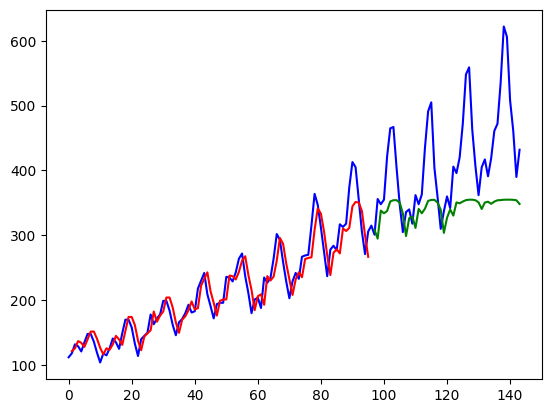

In [99]:
def plot_predicts():
  with torch.no_grad():
      # Зсув прогнозів для тренувальних даних
      train_plot = np.ones_like(passengers_array) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1]
      train_plot[lookback:train_size] = model(X_train)[:, -1]

      # Зсув прогнозів для тестових даних
      test_plot = np.ones_like(passengers_array) * np.nan
      test_plot[train_size+lookback:len(passengers_array)] = model(X_test)[:, -1]

  # Візуалізація результатів
  plt.plot(passengers_array, c='b')  # Реальні дані
  plt.plot(train_plot, c='r')  # Прогнози на тренувальних даних
  plt.plot(test_plot, c='g')   # Прогнози на тестових даних
  plt.show()

plot_predicts()

**Що відбувається в коді вище.** В цьому коді здійснюється процес прогнозування часових рядів за допомогою LSTM моделі, а також виведення графіку, який показує реальні значення, тренувальні та тестові прогнози. Ось що відбувається на кожному етапі:

1. **`torch.no_grad()`**: Цей контекстний менеджер вимикає обчислення градієнтів, що означає, що під час прогнозування не будуть зберігатися проміжні обчислення для зворотного проходу (backpropagation). Це підвищує ефективність під час прогнозування і зменшує використання пам'яті.

2. **Зсув прогнозів для тренувальних даних:**
   - Створюється масив `train_plot`, який має такий самий розмір, як і часовий ряд (`timeseries`), і заповнюється значеннями NaN (`np.nan`), щоб залишити місце для реальних значень.
   - Модель передбачає виходи для тренувальних даних `X_train`.
   - Використовується лише останнє передбачене значення для кожного входу LSTM (`y_pred[:, -1]`).
   - Прогнози зсуваються, починаючи з індексу `lookback` до кінця тренувальних даних (індекс `train_size`). Цей зсув потрібен, щоб зробити прогноз на основі попередніх даних і відобразити його на правильній частині графіку.

3. **Зсув прогнозів для тестових даних:**
   - Створюється масив `test_plot`, який також заповнюється NaN.
   - Прогнози для тестових даних додаються з індексу `train_size + lookback` до кінця реальних даних, щоб відобразити, де модель починає прогнозувати тестову вибірку.

4. **Побудова графіка:**
   - `plt.plot(timeseries, c='b')`: Виводить реальні значення часового ряду (синя лінія).
   - `plt.plot(train_plot, c='r')`: Виводить тренувальні прогнози (червона лінія).
   - `plt.plot(test_plot, c='g')`: Виводить тестові прогнози (зелена лінія).

**Чому це робиться:**
- Зсув прогнозів для тренувальних і тестових даних дозволяє візуально зрівняти, наскільки добре модель прогнозує як на тренувальній, так і на тестовій вибірках. Зазвичай, червона лінія (тренувальні прогнози) повинна точно відповідати синій лінії (реальні дані), а зелена лінія (тестові прогнози) дає змогу побачити, наскільки модель добре працює на нових даних, яких вона раніше не бачила.

**Завдання 8**. Навчіть модель з hidden_size=100 та порівняйте результати прогнозів з попередніми.

In [101]:
# Параметри моделі
input_size = 1  # Кожен вхід - це одна точка часового ряду
hidden_size = 100  # Розмір прихованого шару
num_layers = 1  # Кількість шарів LSTM

# Створюємо модель
model_100 = AirModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)

n_iters = 2000
plot_every = 100
optimizer = torch.optim.Adam(model_100.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Збираємо лоси для графіку
all_epoch_losses = []  # Втрати по епохах
all_batch_losses = []  # Втрати по батчах


for iter in range(n_iters):
    total_loss = 0  # Загальна втрата за епоху

    # Проходимо по кожному батчу
    for xb, yb in train_dl:
        output, loss = train(model_100, criterion, optimizer, xb, yb)
        total_loss += loss

        # Зберігаємо втрату для кожного батчу
        all_batch_losses.append(loss)

    # Обчислюємо середню втрату за епоху
    average_loss = total_loss / len(train_dl)
    all_epoch_losses.append(average_loss)

     # Валідація раз на 100 епох
    if iter % plot_every == 0:
        model_100.eval()
        with torch.no_grad():
            train_outputs = model_100(X_train)
            test_outputs = model_100(X_test)

            train_rmse = torch.sqrt(criterion(train_outputs, y_train)).item()
            test_rmse = torch.sqrt(criterion(test_outputs, y_test)).item()

            print(f'Epoch {iter}: train RMSE: {train_rmse:.4f}, test RMSE: {test_rmse:.4f}')

Epoch 0: train RMSE: 225.7876, test RMSE: 422.1633
Epoch 100: train RMSE: 146.1996, test RMSE: 337.4483
Epoch 200: train RMSE: 97.5293, test RMSE: 278.4058
Epoch 300: train RMSE: 68.2212, test RMSE: 234.2394
Epoch 400: train RMSE: 48.8344, test RMSE: 197.5023
Epoch 500: train RMSE: 36.8167, test RMSE: 168.6577
Epoch 600: train RMSE: 30.9759, test RMSE: 146.4013
Epoch 700: train RMSE: 27.7137, test RMSE: 128.6405
Epoch 800: train RMSE: 25.3118, test RMSE: 116.3740
Epoch 900: train RMSE: 24.9702, test RMSE: 107.7551
Epoch 1000: train RMSE: 23.8980, test RMSE: 102.1339
Epoch 1100: train RMSE: 23.5466, test RMSE: 97.6417
Epoch 1200: train RMSE: 23.3178, test RMSE: 94.9358
Epoch 1300: train RMSE: 23.5665, test RMSE: 93.2745
Epoch 1400: train RMSE: 23.3933, test RMSE: 92.7226
Epoch 1500: train RMSE: 23.2697, test RMSE: 90.2434
Epoch 1600: train RMSE: 23.4374, test RMSE: 87.2006
Epoch 1700: train RMSE: 23.3909, test RMSE: 89.5211
Epoch 1800: train RMSE: 24.4648, test RMSE: 90.1685
Epoch 1900:

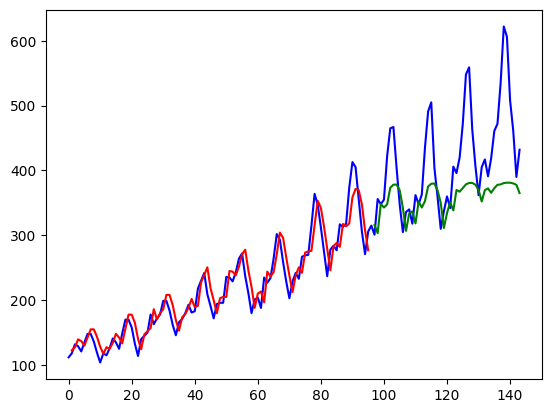

In [102]:
def plot_predicts(model):
  with torch.no_grad():
      # Зсув прогнозів для тренувальних даних
      train_plot = np.ones_like(passengers_array) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1]
      train_plot[lookback:train_size] = model(X_train)[:, -1]

      # Зсув прогнозів для тестових даних
      test_plot = np.ones_like(passengers_array) * np.nan
      test_plot[train_size+lookback:len(passengers_array)] = model(X_test)[:, -1]

  # Візуалізація результатів
  plt.plot(passengers_array, c='b')  # Реальні дані
  plt.plot(train_plot, c='r')  # Прогнози на тренувальних даних
  plt.plot(test_plot, c='g')   # Прогнози на тестових даних
  plt.show()

plot_predicts(model_100)

**Висновки:**
Дані навчання показують менші втрати на тестових даних, але модель не враховує тренд в даних.